## importing needed libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import tweepy
from textblob import TextBlob
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pickle

# Testing on random user by entering userid at runtime

## taking input as userid to predict trustworthiness of user

In [2]:
inputuserid = input("Enter twitter userid of user= ")

Enter twitter userid of user= BillGates


## extracting user's profile data  and performing prediction on user profile 

In [5]:
consumer_key = "uI8rlEbmxT108GTsVH4OX0SQi" 
consumer_secret = "mn5GPEYvyZE0NoZ6lV1GEB6iszs1R9PXsfxZLGPvVcyhm44FOb"
access_key = "1433079307811766278-X5jzunomTlbMVX4Fxvul7nkLacKqyN"
access_secret = "c6QWgpx34jce0QiVkVsrBF1cDJ6JyS3vqVm4AyO7od3H1"

# Twitter authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)   
auth.set_access_token(access_key, access_secret) 
  
# Creating an API object 
api = tweepy.API(auth)

arcgishub_tweets = []
def profile_Analysis():
    info = {}

    new_tweets = tweepy.Cursor(api.user_timeline, screen_name=inputuserid, tweet_mode='extended').items()
    
    for tweet in new_tweets:
        arcgishub_tweets.append(tweet._json) 
    
    if(len(arcgishub_tweets) == 0):
        profile_score = 0
        return profile_score
    
    user = arcgishub_tweets[0]
    
    dic = user['user']
    dic.pop('entities')
    info[inputuserid] = dic

    inpdf = pd.DataFrame(info)

    inpdf = inpdf.transpose()

    inpdf = inpdf[['protected',
     'followers_count',
     'friends_count',
     'listed_count',
     'created_at',
     'favourites_count',
     'geo_enabled',
     'verified',
     'statuses_count',
     'contributors_enabled',
     'has_extended_profile',
     'default_profile']]

    temp = inpdf['created_at']
    templist = []

    for i in inpdf['created_at']:
    
        templist.append(int(2021) - int(i.split()[5]))

    inpdf['created_at'] = templist


    inpdf = inpdf.replace({
        True: 1,
        False: 0,
    })


    loaded_model = pickle.load(open('finalized_model.sav', 'rb'))

    profile_score = loaded_model.predict(inpdf)
    return profile_score
    
profile_score = profile_Analysis()
print("User trustworthiness scores from user profile: ",profile_score)

User trustworthiness scores from user profile:  [1]


## performing text classification for positive, negative or nutral score of tweets and bio descriptions and predicting from user's textual content

Unexpected parameter: lang


******Word Cloud Visulization of textual content and relativity with graph*****


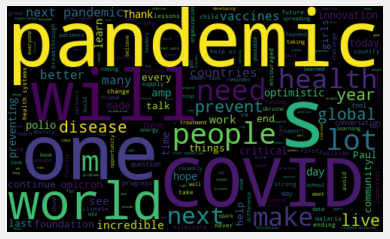


*****Plotting Overall Sentiment Analysis of textual content*****


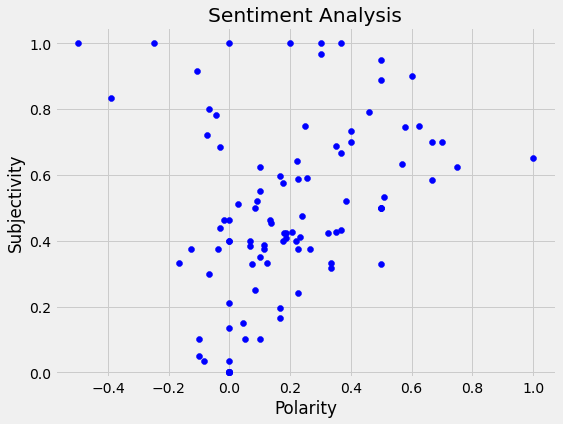

Total Percentage of Positive textual content of user =  67.3
Total Percentage of Negative textual content of user =  16.8
Total value counts: 
Positive    68
Negative    17
Neutral     16
Name: Analysis, dtype: int64


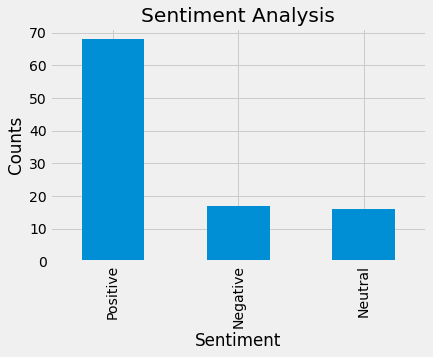

In [6]:
data1 = [[arcgishub_tweets[0]['user']['description']]]

df2 = pd.DataFrame(data1,columns = ['Tweets'])

posts = api.user_timeline(screen_name=inputuserid, count = 100, lang ="en", tweet_mode="extended")

df = pd.DataFrame([tweet.full_text for tweet in posts], columns=['Tweets'])
df = df.append(df2,ignore_index = True)

def cleanTxt(text):
    text = re.sub('@[A-Za-z0–9]+', '', text) #Removing @mentions
    text = re.sub('#', '', text) # Removing '#' hash tag
    text = re.sub('RT[\s]+', '', text) # Removing RT
    text = re.sub('https?:\/\/\S+', '', text) # Removing hyperlink
 
    return text

df['Tweets'] = df['Tweets'].apply(cleanTxt)


def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def getPolarity(text):
    return  TextBlob(text).sentiment.polarity


# Create two new columns 'Subjectivity' & 'Polarity'
df['Subjectivity'] = df['Tweets'].apply(getSubjectivity)
df['Polarity'] = df['Tweets'].apply(getPolarity)

# Show the new dataframe with columns 'Subjectivity' & 'Polarity'

print("******Word Cloud Visulization of textual content and relativity with graph*****")

allWords = ' '.join([twts for twts in df['Tweets']])
wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(allWords)


plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#print("*********Subjectivity, polarity and Analysis of textual content*********")
preds = float(profile_score)
def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'
df['Analysis'] = df['Polarity'].apply(getAnalysis)
# Show the dataframe
#print(df)

print()

print("*****Plotting Overall Sentiment Analysis of textual content*****")


plt.figure(figsize=(8,6)) 
for i in range(0, df.shape[0]):
  plt.scatter(df["Polarity"][i], df["Subjectivity"][i], color='Blue') 
# plt.scatter(x,y,color)   
plt.title('Sentiment Analysis') 
plt.xlabel('Polarity') 
plt.ylabel('Subjectivity') 
plt.show()

ptweets = df[df.Analysis == 'Positive']
ptweets = ptweets['Tweets']
ptweets

positivecount = round( (ptweets.shape[0] / df.shape[0]) * 100 , 1)
print('Total Percentage of Positive textual content of user = ', positivecount)


ntweets = df[df.Analysis == 'Negative']
ntweets = ntweets['Tweets']
ntweets

negativecount = round( (ntweets.shape[0] / df.shape[0]) * 100, 1)


print('Total Percentage of Negative textual content of user = ', negativecount)

print("Total value counts: ")
print(df['Analysis'].value_counts())


plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
df['Analysis'].value_counts().plot(kind = 'bar')
plt.show()

# Final output with scores

#### here 1.0 means user is trustworthy and 0.0 means user is not trustworthy

In [7]:
avgscore = (profile_score + (positivecount/100))/2

print(inputuserid,"is trustworthy from user's profile is ",preds,end='\n')
print(inputuserid," classification score based on textual content is ", positivecount/100,end='\n')

percentage = avgscore*100
print("Probability that ",inputuserid, "is trustworthee is",percentage,'%')

BillGates is trustworthy from user's profile is  1.0
BillGates  classification score based on textual content is  0.6729999999999999
Probability that  BillGates is trustworthee is [83.65] %
